<a href="https://colab.research.google.com/github/cognitedata/cognite-python-docs/blob/visualizing-open-industrial-data/examples/basics/visualising_open_industrial_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualising Open Industrial Data

## What this notebook will achieve

* Extract live data from an oil rig in the North Sea.

* Visualize and inspect data directly from the Cognite Data Fusion.



## Getting started

* Having a basic understanding of Python concepts will help to understand the process.

* Cognite has released *live* data to the public on Cognite Data Fusion streaming from [Valhall](https://www.akerbp.com/en/our-assets/production/valhall/), one of Aker's oil fields.

* To access the data, generate an API Key on [Open Industrial Data](https://openindustrialdata.com/). Get your key via the Google Access platform. You will be asked to fill out some personal information to generate your personal key.

* Visualize some of the machines (assets) on Valhall with Cognite's [Operational Intelligence](https://opint.cogniteapp.com/publicdata/infographics/-LOHKEJPLvt0eRIZu8mE) dashboard. This data on this page shows is streaming live data from the Valhall oil field located in the North Sea.

* To understand how to interact with the data using the Python SDK ([Docs](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/)) follow along in this notebook.

## Environment Setup

#### Install the Cognite SDK package

In [1]:
!pip install cognite-sdk
!pip install --upgrade numpy

Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple
Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple
Requirement already up-to-date: numpy in /Users/rebeccawiborgseyfarth/miniconda3/lib/python3.7/site-packages (1.16.4)


#### Import the required packages

In [2]:
%matplotlib inline

import os
from datetime import datetime, timedelta
from datetime import datetime
from getpass import getpass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from cognite.client import CogniteClient

#### Connect to the Cognite Data Fusion
* This client object is how all queries will be sent to the Cognite API to retrieve data.

When prompted for your API key, use the key generated by open industrial data as mentioned in the Getting Started steps.

In [3]:
client = CogniteClient(api_key=getpass("Open Industrial Data API-KEY: "), client_name="OID_example")

Open Industrial Data API-KEY: ········


/usr/local/lib/python3.7/site-packages/cognite/client/_cognite_client.py:57: UserWarning: You are using version 1.0.0a35 of the SDK, however version 1.0.0b1 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  debug=debug,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Authenticated towards inferred project 'publicdata'. Pass project to the CogniteClient constructor or set the environment variable 'COGNITE_PROJECT' to suppress this warning.
  """Entry point for launching an IPython kernel.


## Accessing Cognite Data Fusion (CDF)
* The CDF organizes digital information about the physical world.
* There are 6 kinds of objects stored on the CDF. Each of these objects in CDF are labelled with a unique ID. Information regarding a specific Asset, Event, etc are often retrieved using this ID.

  * [Assets](https://doc.cognitedata.com/api/0.5/#tag/Assets) are digital representations of physical objects or groups of objects, and assets are organized into an asset hierarchy. For example, an asset can represent a water pump which is part of a subsystem on an oil fusion.
  
  * [Event](https://doc.cognitedata.com/api/0.5/#tag/Events) objects store complex information about multiple assets over a time period. For example, an event can describe two hours of maintenance on a water pump and some associated pipes.
  
  * A [File](https://doc.cognitedata.com/api/0.5/#tag/Files) stores a sequence of bytes connected to one or more assets. For example, a file can contain a piping and instrumentation diagram (P&IDs) showing how multiple assets are connected.
  
  * A [Time Series](https://doc.cognitedata.com/api/0.5/#tag/Time-series) consists of a sequence of data points connected to a single asset. For example: A water pump asset can have a temperature time series that records a data point in units of °C every second.
  
  * [Sequence](https://doc.cognitedata.com/api/0.5/#tag/Sequences) are similar to time series in that they are a key value pair, but rather than using a timestamp as the key, another measurment such as depth could be the key. For example, this is used in practice when drilling and taking measurments at various depths.
  
  * A [3D](https://doc.cognitedata.com/api/0.5/#tag/3D) model is typically built up by a hierarchical structure. This looks very similar to how we organize our internal asset hierarchy. 3D models are visualized via Cognite's dashboards.
  
* It is important to refer back to the [SDK](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html) for specific details on arguments on all avaiable methods on how to access these objects.

### Collecting Time Series Information and Data Points

* Time Series objects contain the bulk of information in the CDF.

* Time Series objects are generally linked to an asset through the asset_id field.

* The *time_series.list()* method has a variety of filters, all are listed in the SDK.

To get all time series available in the project, we can do like this:

In [4]:
all_timeseries = client.time_series.list(limit=-1).to_pandas()
print(len(all_timeseries))
all_timeseries.head()

363


,assetId,createdTime,description,externalId,id,isStep,isString,lastUpdatedTime,metadata,name,unit
0,3424990723231138,0,PH (Profiler) Shutdown Channel 0 - Tube y Posi...,VAL_23-LY-92529_SILch0_SC0_TYPSP:VALUE,35246780681261,False,False,0,{'tag': 'VAL_23-LY-92529_SILch0_SC0_TYPSP:VALU...,VAL_23-LY-92529_SILch0_SC0_TYPSP:VALUE,NaN
1,4293345866058133,0,PH 1stStg LO Cooler CW,VAL_45-FT-92139B:X.Value,41852231325889,False,False,0,"{'tag': 'VAL_45-FT-92139B:X.Value', 'scan': '1...",VAL_45-FT-92139B:X.Value,NaN
2,5826132550305704,0,PH 1stStg Lube Oil Reservoir,VAL_23-LT-96182-03:X.Value,44435358976768,False,False,0,"{'tag': 'VAL_23-LT-96182-03:X.Value', 'scan': ...",VAL_23-LT-96182-03:X.Value,NaN
3,7271158805875629,0,PH 1stStg Comp Thrust BRG IN,VAL_23-TT-96103-03:Z.X.Value,81505042780431,False,False,0,"{'tag': 'VAL_23-TT-96103-03:Z.X.Value', 'scan'...",VAL_23-TT-96103-03:Z.X.Value,NaN
4,6191827428964450,0,PH (SwitchGear) MV-COMP.M. FEEDER/ 51-3 Non D...,VAL_23-KA-9101-M01_OC_instantaneous_residual_N...,82185797798532,False,False,0,{'tag': 'VAL_23-KA-9101-M01_OC_instantaneous_r...,VAL_23-KA-9101-M01_OC_instantaneous_residual_N...,NaN


If you are curious about which asset a time series is attached to, you can retrieve more information of the asset by:

In [5]:
client.assets.retrieve(id=2853212781345885).to_pandas()

,value
name,23-ESDV-92501A-PST
parentId,576308321452985
description,SOFT TAG VRD - PH 1STSTGSUCTCLR GAS IN
id,2853212781345885
createdTime,0
lastUpdatedTime,0
rootId,6687602007296940
ELC_STATUS_ID,1211
SOURCE_DB,workmate
SOURCE_TABLE,wmate_dba.wmt_tag


#### View datapoints for one of the time series

* Now that we have a list of time series, we can retrieve datapoints for some of the them.

* The returned object is a data frame with

  * timestamp which is time in milliseconds as index
  
  * value which is the reading from the sensor as columns
  
The identifier to retrieve Datapoints is the **id** or the external id equal to the **name** column from the DataFrame above.

In [6]:
client.datapoints.retrieve(external_id="VAL_45-PT-92508:X.Value", start="10d-ago", end="now").to_pandas().head()

,VAL_45-PT-92508:X.Value
2019-07-01 09:47:36.095,2.313878
2019-07-01 09:47:46.077,2.316213
2019-07-01 09:47:57.014,2.320363
2019-07-01 09:48:04.982,2.324514
2019-07-01 09:48:16.945,2.325811


## Visualising the data in the CDF

* The rest of the notebook will be used to retrieve and visualize data

* The sensor are chosen because they are specifically good if you later want to try to create a model that predicts one sensor from the others.

#### Collect datapoints from CDF

* The following four time series measures the input flow rate, pressure, and temperature and the output pressure from a suction cooler

  * FT: Input Flow Rate
  
  * PT: Input Pressure
  
  * TT: Input Temperature

  * Output Pressure

  
The time series names are defined in the *in_ts_names* and *out_ts_names* lists below.
  

In [7]:
in_ts_names = ["VAL_23-FT-92512:X.Value", "VAL_23-PT-92512:X.Value", "VAL_23-TT-92502:X.Value"]
out_ts_name = "VAL_23-PT-92504:X.Value"

#### Retrieve Data Points from CDF

* Datapoints are returned in a pandas dataframe using the method *datapoints.retrieve().to_pandas()*, [documentation](https://cognite-docs.readthedocs-hosted.com/projects/cognite-sdk-python/en/latest/cognite.html#retrieve-multiple-time-series-by-id).

* The common timestep is assigned using *granularity* argument. In this case, 1 minute was chosen.

In [8]:
ts_names = in_ts_names + [out_ts_name]

train_start_date = datetime(2018, 8, 1)
# 30 days of training data chosen arbitrarily
train_end_date = train_start_date + timedelta(days=30)

datapoints_df = client.datapoints.retrieve(external_id=ts_names,
                                           aggregates=['average'],
                                           granularity='1m',
                                           start=train_start_date,
                                           end=train_end_date
                                           ).to_pandas()
datapoints_df.fillna(method="ffill", inplace = True)
datapoints_df.head()

,VAL_23-FT-92512:X.Value|average,VAL_23-PT-92512:X.Value|average,VAL_23-TT-92502:X.Value|average,VAL_23-PT-92504:X.Value|average
2018-08-01 00:00:00,91120.918480,3.374376,44.184863,3.251437
2018-08-01 00:01:00,86259.975220,3.395966,44.232420,3.274299
2018-08-01 00:02:00,90750.665657,3.410101,44.161438,3.287578
2018-08-01 00:03:00,91948.525170,3.358822,43.986025,3.237081
2018-08-01 00:04:00,93779.111997,3.429458,43.797913,3.306391


In [9]:
datapoints_df.isna().any()

VAL_23-FT-92512:X.Value|average    False
VAL_23-PT-92512:X.Value|average    False
VAL_23-TT-92502:X.Value|average    False
VAL_23-PT-92504:X.Value|average    False
dtype: bool

In [10]:
# Remove "|average"
datapoints_df.rename(columns=lambda x: x[:-8] if x != "timestamp" else x, inplace=True)
datapoints_df.head()

,VAL_23-FT-92512:X.Value,VAL_23-PT-92512:X.Value,VAL_23-TT-92502:X.Value,VAL_23-PT-92504:X.Value
2018-08-01 00:00:00,91120.918480,3.374376,44.184863,3.251437
2018-08-01 00:01:00,86259.975220,3.395966,44.232420,3.274299
2018-08-01 00:02:00,90750.665657,3.410101,44.161438,3.287578
2018-08-01 00:03:00,91948.525170,3.358822,43.986025,3.237081
2018-08-01 00:04:00,93779.111997,3.429458,43.797913,3.306391


#### Visualize the Time Series data
* Utilize matplotlib to visualize each of the time series plots

The bottom right plot is the output time series, while the other 3 are the inputs used to create an estimate for the output.

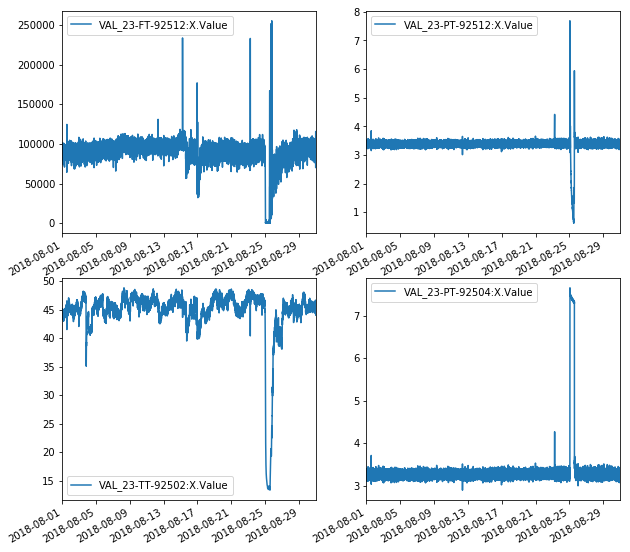

In [11]:
cols = list(datapoints_df.columns)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, col in enumerate(cols):
    datapoints_df.loc[:, [col]].plot(ax=axes[int(i>1), i%2])